In [1]:
# Set up the environment
from matplotlib import pyplot as plt
from myst_nb import glue

import numpy as np

import xml_book.meta_explainers.plot_examples as plot_examples
import xml_book.plots.arrays as arrays

(text:meta-explainers:surrogates:overview)=
# Overview #

To better understand surrogate explainers, we discuss them on multiple levels: abstract, theoretical and algorithmic, for image, text and tabular data.
Next, we overview explanations that can be generated with surrogate trees and linear models; introduce evaluation criteria and strategies; go through caveats of surrogate explainers; and present relevant literature.
You can navigate through these sections using the right-hand side *Contents* panel.

````{admonition} Mathematical Notation Summary
:class: note, dropdown

```{list-table}
:header-rows: 1
:name: text:meta-explainers:surrogates:maths

* - Symbol
  - Meaning
* - $\mathcal{X}$
  - Original representation of data.
* - $\mathcal{X}^\prime$
  - Interpretable representation of data.
* - $X$
  - A subset of data in the original representation $X \subseteq \mathcal{X}$.
* - $X^\prime$
  - A subset of data in the interpretable representation $X^\prime \subseteq \mathcal{X}^\prime$.
* - $x$
  - A data point in the original representation $x \in \mathcal{X}$.
* - $x^\prime$
  - A data point in the interpretable representation $x^\prime \in \mathcal{X}^\prime$.
* - $\mathring{x}$
  - A data point selected to be explained in the original representation $\mathring{x} \in \mathcal{X}$.
* - $\mathring{x}^\prime$
  - A data point selected to be explained in the interpretable representation $\mathring{x}^\prime \in \mathcal{X}^\prime$.
* - $\mathcal{Y}$
  - The label space of the data $\mathcal{X}$.
    For crisp classification it encodes unique classes $c \in \mathcal{Y}$;
    for probabilistic classification $\mathcal{Y} \;\colon= \left[ 0, 1 \right]^C$, where $C$ is the set of all classes and $c \in C$ denotes an individual class; and
    for regression it is a numerical range, e.g., $\mathcal{Y} \equiv \mathbb{R}$.
* - $Y$
  - Labels $Y \subseteq \mathcal{Y}$ for a subset of data $X \subseteq \mathcal{X}$.
* - $\mathring{C}$
  - A subset of classes $\mathring{C} \subseteq \mathcal{Y}$ selected to be explained.
* - $\mathring{c}$
  - A class $\mathring{c} \in \mathcal{Y}$ selected to be explained.
* - $d$
  - Dimensionality -- i.e., number of features -- of the data space $\mathcal{X}$.
* - $d^\prime$
  - Dimensionality -- i.e., number of features -- of the *interpretable* data space $\mathcal{X}^\prime$.
* - $\mathcal{F} : \mathcal{X} \mapsto \mathcal{Y}$
  - A family of black-box models compatible with the explainer.
    If the model family represents probabilistic or crisp classifiers, a subscript $c$ -- i.e., $f_c \in \mathcal{F}$ -- is used to indicate that it outputs: a probability of class $c$ for the former type; and for the latter $1$ if the predicted class is $c$ and $0$ otherwise (refer to {eq}`eq:meta-explainers:surrogates:crisp-classification-target`).
* - $f \in \mathcal{F}$
  - A black-box model being investigated.
* - $\mathcal{G} : \mathcal{X}$ or $\mathcal{X}^\prime \mapsto [0, 1]$ or $\{0, 1\}$ or $\mathcal{Y}$
  - A family of inherently transparent and human-comprehensible models that can be used as surrogates.
    These models can be fitted to the original $\mathcal{X}$ (specific to tabular) or interpretable $\mathcal{X}^\prime$ (tabular, image and text) data representation.
    They are trained to model the probability of a selected class ($[0, 1]$) for probabilistic classifiers, the $\{0, 1\}$ encoding of a selected class for crisp models, and a numerical output, e.g., $\mathbb{R}$, for regressors.
* - $g \in \mathcal{G}$
  - A surrogate model used for explanation generation.
* - $\IR : \mathcal{X} \mapsto \mathcal{X}^\prime$
  - A (user-provided) transformation function from the original into the interpretable domain.
    The inverse transformation is dented with $\IR^{-1}$.
* - $L : \mathcal{X} \times \mathcal{X} \mapsto \mathbb{R}$ or <br> $L : \mathcal{X}^\prime \times \mathcal{X}^\prime \mapsto \mathbb{R}$
  - A distance metric compatible with either the original $\mathcal{X}$ or interpretable $\mathcal{X}^\prime$ data domain.
* - $k : \mathbb{R} \mapsto \mathbb{R}$
  - A kernel transforming distances into similarity scores.
* - $\omega : \mathcal{X} \times \mathcal{X} \mapsto \mathbb{R}$ or <br> $\omega : \mathcal{X}^\prime \times \mathcal{X}^\prime \mapsto \mathbb{R}$
  - A weighting function that captures the proximity or similarity of an instance to the explained data point, operating either in the original $\mathcal{X}$ or interpretable $\mathcal{X}^\prime$ data domain.
    It is usually defined as $\omega = k \circ L$.
* - $\Omega : \mathcal{G} \mapsto \mathbb{R}$
  - A function that measures complexity of a surrogate model as perceived by a human {term}`explainee`; for example, the number of non-zero (or significantly larger than zero) parameters of a linear model, or a size (depth or width) of a decision tree.
* - $\mathcal{L} : \mathcal{F} \times \mathcal{G} \mapsto \mathbb{R}$
  - A function that calculates the quality of a surrogate model by assessing how well it mimics the predictions of the explained black box (also known as {term}`fidelity`).
* - $\mathcal{O}$
  - The optimisation objective used to construct surrogate models.
    See {eq}`eq:meta-explainers:surrogates:optimisation` for the definition.
* - ${\Large\mathbb{1}} : \mathbb{R} \mapsto \{0, 1\}$
  - An indicator function for a specific condition, e.g.,

    $$
     {\Large\mathbb{1}}\left(x\right) =
     \begin{cases}
       1, & \text{if} \;\; x > 0\\
       0, & \text{otherwise}
     \end{cases}
     \text{ .}
    $$
```
````

## Building Surrogates ##

The introduction to {numref}`Chapter %s<text:meta-explainers:surrogates>` provided a high-level overview of surrogate explainers.
It also outlined the three fundamental components of the {term}`bLIMEy` framework:

* interpretable data representation composition (step 1),
* data sampling (steps 2--4) and
* explanation generation (steps 5--8),

which can be codified in a *meta-algorithm* as shown by {prf:ref}`algo:meta-explainers:surrogates:blimey`, with the *steps* corresponding to each module listed in parentheses.
In this process, $\IR : \mathcal{X} \mapsto \mathcal{X}^\prime$ is a function transforming data from their original domain $\mathcal{X}$ into the interpretable representation $\mathcal{X}^\prime$;
$X^\prime \subseteq \mathcal{X}^\prime$ are data sampled in the interpretable representations and transformed to the original $\IR^{-1}(X^\prime) = X \subseteq \mathcal{X}$;
$f \in \mathcal{F} : \mathcal{X} \mapsto \mathcal{Y}$ is the black-box model being explained, with a $\mathring{c}$ subscript -- i.e., $f_\mathring{c}$ -- indicating the user-selected class to be predicted (and explained); and
$\omega : \mathcal{X}^\prime \times \mathcal{X}^\prime \mapsto \mathbb{R}$ is a function measuring similarity between two instances.
Note that sampling (step 2) and similarity calculation (step 5) are done in the interpretable representation $\mathcal{X}^\prime$, but these operations can also be performed in the original domain $\mathcal{X}$ (with certain caveats).
Additionally, the order of steps 5 and 6 -- which are *optional* -- can be inverted.
Refer to the *{ref}`Mathematical Notation Summary<text:meta-explainers:surrogates:maths>`* box at the top of this page for an overview of mathematical notation used throughout this chapter.

```{prf:algorithm} bLIMEy meta-algorithm
:label: algo:meta-explainers:surrogates:blimey

**Inputs:** an instance to be explained $\mathring{x}$, a class $\mathring{c}$ for which to explain this instance, and a black-box model $f$.

**Output:** an explanation $e$.

1. $\mathring{x}^\prime \gets \IR(\mathring{x})$
2. $X^\prime \gets \mathtt{sample\_data}(\mathring{x}^\prime, \;\; \mathtt{scope}=\{\mathtt{local},\; \mathtt{cohort},\; \mathtt{global}\})$ *(done in $\mathcal{X}^\prime$)*
3. $X \gets \IR^{-1}(X^\prime)$
4. $y \gets f_\mathring{c}(X)$
5. $w \gets \omega(\mathring{x}^\prime, \; X^\prime)$ *(get weights)*
6. $\overline{X}^\prime \gets \mathtt{reduce\_dimensionality}(X^\prime)$
7.  $g \gets \mathtt{fit\_surrogate}(\overline{X}^\prime, \; y, \; \mathtt{sample\_weight}=w)$
8.  $e \gets \mathtt{extract\_explanation}(g)$
```

A toy example of this meta-algorithm being executed for two-dimensional tabular data with numerical features is shown in {numref}`fig:surrogates:full_overview`.
In this particular case we do not use an interpretable representation to offer more clarity and a better intuition of the process.
Therefore, the representation transformations are not needed (steps 1 and 3);
the data are sampled in their original domain $\mathcal{X}$ (step 2);
the similarity is computed in the original domain $\mathcal{X}$ as well (step 5);
the dimensionality reduction is not needed (step 6); and
the surrogate is fitted onto the data sample in the original domain $\mathcal{X}$ (step 7).

<Figure size 1000x600 with 0 Axes>

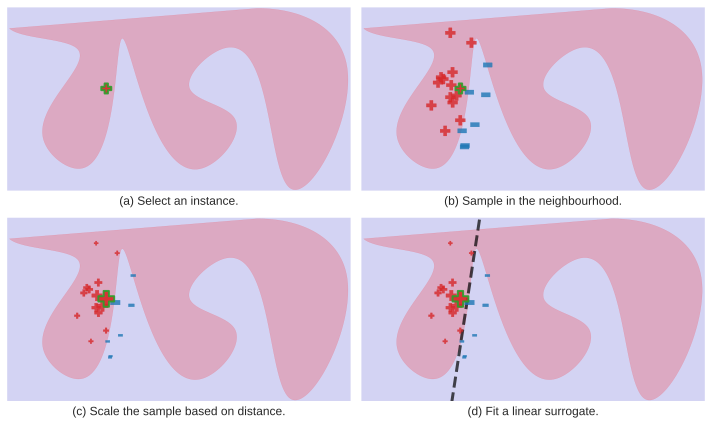

In [2]:
figsize_all = (2 * 5, 2 * 3)
fig = plt.figure(figsize=figsize_all)
fig, ax = plt.subplots(2, 2, figsize=figsize_all)

figsize_piece = (5, 3)
title_loc = -0.11
fig1, ax1 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[0, 0], figsize=figsize_piece,
    plot_line=False, scale_points=False, plot_sample=False)
ax1.set_title('(a) Select an instance.', y=title_loc)
fig2, ax2 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[0, 1], figsize=figsize_piece, plot_line=False, scale_points=False)
ax2.set_title('(b) Sample in the neighbourhood.', y=title_loc)
fig3, ax3 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[1, 0], figsize=figsize_piece, plot_line=False, scale_points=True)
ax3.set_title('(c) Scale the sample based on distance.', y=title_loc)
fig4, ax4 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[1, 1], figsize=figsize_piece, plot_line=True, scale_points=True)
ax4.set_title('(d) Fit a linear surrogate.', y=title_loc)

glue('fig_surrogates_fullOverview', fig, display=False)

```{glue:figure} fig_surrogates_fullOverview
:figwidth: 95%
:name: "fig:surrogates:full_overview"

Steps required to build a *local*, *linear* surrogate explainer for two-dimensional, numerical *tabular data* without an interpretable representation.
Panel (a) shows an instance selected to be explained for the black box whose decision boundary is shown by the blue and red background shading.
Panel (b) depicts a collection of data sampled locally around the explained instance.
Panel (c) illustrates similarity between this data sample and the explained instance using distance-based weighting.
Finally, Panel (d) captures a surrogate linear model approximating the black-box decision boundary in this region.
```

### Optimisation Objective ###

Formally, surrogates are built by optimising the objective $\mathcal{O}$ given in {eq}`eq:meta-explainers:surrogates:optimisation`.
It balances the (human {term}`explainee`-perceived) complexity $\Omega : \mathcal{G} \mapsto \mathbb{R}$ of the surrogate model $g \in \mathcal{G}$, which is chosen from the space of a transparent family of models $\mathcal{G}$, against this model's ability to approximate the explained black box $\mathcal{L} : \mathcal{F} \times \mathcal{G} \mapsto \mathbb{R}$, where $f \in \mathcal{F}$ is the opaque model drawn from a family of models $\mathcal{F}$ compatible with this explainer.
The surrogate model may be fitted to the original $\mathcal{X}$ or the interpretable $\mathcal{X}^\prime$ domain if one is used.
It can either target the probability of a selected class ($[0, 1]$) for probabilistic classifiers $\mathcal{F}$, the $\{0, 1\}$ encoding of a selected class for crisp models $\mathcal{F}$, or a numerical output, e.g., $\mathbb{R}$, for regressors $\mathcal{F}$.

$$
  \mathcal{O}(\mathcal{G}; \; f) =
  \argmin_{g \in \mathcal{G}}
  \overbrace{\Omega(g)}^{\text{complexity}} \; + \;\;\;
  \overbrace{\mathcal{L}(f, g)}^{\text{fidelity loss}}
$$ (eq:meta-explainers:surrogates:optimisation)

### Complexity ###

The complexity $\Omega$, for example, can be the number of non-zero (or *substantially* larger than zero) parameters of a linear model ({eq}`eq:meta-explainers:surrogates:complexity-linear`, where $\Theta_g$ are the coefficients of the surrogate and ${\Large\mathbb{1}} : \mathbb{R} \mapsto \{0, 1\}$ is an indicator function), or the size -- depth or width -- of a decision tree ({eq}`eq:meta-explainers:surrogates:complexity-tree`, where $d$ is the dimensionality of the data space $\mathcal{X}$).

$$
  \Omega(g) = \frac{\sum_{\theta \in \Theta_g} {\Large\mathbb{1}} \left(\theta\right)}{|\Theta_g|}
$$ (eq:meta-explainers:surrogates:complexity-linear)

$$
  \Omega(g; \; d) = \frac{\text{depth}(g)}{d}
  \;\;\;\;\text{or}\;\;\;\;
  \Omega(g; \; d) = \frac{\text{width}(g)}{2^d}
$$ (eq:meta-explainers:surrogates:complexity-tree)

### Fidelity Loss (One Class) ###

The second component of the optimisation objective $\mathcal{O}$ -- the {term}`fidelity` loss of the surrogate explainer $\mathcal{L} : \mathcal{F} \times \mathcal{G} \mapsto \mathbb{R}$ -- measures how well the surrogate model mimics the predictions of the explained black box (more specifically, its decision surface contained within the subspace of interest and determined by the data sampled in this region).

---

The formulation of fidelity $\mathcal{L}$ depends on the type of the explained black box.
For *regressors* and *probabilistic classifiers* it is based on a weighted -- determined by the proximity $\omega(\cdot, \cdot)$ of each instance to the explained data point -- squared error;
in the latter scenario the numerical optimisation uses the probability of a single class $\mathring{c}$ selected by the user to be explained.
In both cases the surrogate model is a regressor.
{eq}`eq:meta-explainers:surrogates:loss-regression` defines the loss for these two cases, with the calculations performed on a data set $X^\prime$ captured in the interpretable representation $\mathcal{X}^\prime$, the weighting $\omega(\cdot, \cdot)$ also done in the interpretable space $\mathcal{X}^\prime$, and the surrogate model $g$ operating on the interpretable domain $\mathcal{X}^\prime$ as well.

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{c}) =
  \sum_{x^\prime \in X^\prime} \;
  \underbrace{\omega\left( \IR(\mathring{x}), x^\prime \right)}_{\text{weighting factor}}
  \; \times \;
  \underbrace{\left(f_\mathring{c}\left(\IR^{-1}(x^\prime)\right) - g(x^\prime)\right)^{2}}_{\text{individual loss}}
$$ (eq:meta-explainers:surrogates:loss-regression)

---

The loss $\mathcal{L}$ for *crisp classification* is inspired by predictive accuracy -- see {eq}`eq:meta-explainers:surrogates:loss-classification`.
Here, the *individual loss* component (the underscored part of {eq}`eq:meta-explainers:surrogates:loss-classification`) is based on an indicator function whose role depends on whether the black box is a binary or multi-class classifier and how the local model is trained.
Specifically, after choosing a class to be explained $\mathring{c}$, we encode the output of the explained model $f$ as $1$ if it is $\mathring{c}$ and $0$ otherwise, i.e.:

$$
f_{\mathring{c}}(x) =
\begin{cases}
  1, & \text{if} \;\; f(x) \equiv \mathring{c}\\
  0, & \text{if} \;\; f(x) \not\equiv \mathring{c}
\end{cases} \text{ .}
$$ (eq:meta-explainers:surrogates:crisp-classification-target)

This representation is used as target when training the surrogate model, which in this case is a *crisp binary classifier*.
Then, the indicator function in {eq}`eq:meta-explainers:surrogates:loss-classification` becomes:

$$
{\Large\mathbb{1}}\left(f_{\mathring{c}}(x), g(x^\prime)\right) =
\begin{cases}
  1, & \text{if} \;\; f_{\mathring{c}}(x) \equiv g(x^\prime)\\
  0, & \text{if} \;\; f_{\mathring{c}}(x) \not\equiv g(x^\prime)
\end{cases} \text{ ,}
$$

where $x^\prime = \IR(x)$.
For example, for three classes $\mathcal{Y} \colon= \{\alpha, \beta, \gamma\}$, $\mathring{c} \equiv \beta$ and some surrogate $g$:
```{list-table}
:header-rows: 1
:class: centre-table

* - $f(x)$
  - $f_\beta(x)$
  - $g(x^\prime)$
  - ${\Large\mathbb{1}}$
* - $\alpha$
  - $0$
  - $1$
  - $0$
* - $\beta$
  - $1$
  - $0$
  - $0$
* - $\gamma$
  - $0$
  - $0$
  - $1$
* - $\beta$
  - $1$
  - $1$
  - $1$
* - $\alpha$
  - $0$
  - $0$
  - $1$
```

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{c}) =
  \sum_{x^\prime \in X^\prime} \;
  \omega\left( \IR(\mathring{x}), x^\prime \right)
  \; \times \;
  \underline{ {\Large\mathbb{1}} \left(f_\mathring{c}\left(\IR^{-1}(x^\prime)\right), \; g(x^\prime)\right)}
$$ (eq:meta-explainers:surrogates:loss-classification)

---

The *weighting* function $\omega$ captures the proximity or similarity between the explained instance ($\mathring{x}$) and the data sampled in its neighbourhood ($X^\prime$).
It is usually defined as $\omega = k \circ L$, where $L : \mathcal{X}^\prime \times \mathcal{X}^\prime \mapsto \mathbb{R}$ is a distance metric and $k : \mathbb{R} \mapsto \mathbb{R}$ is a kernel transforming distances into similarity scores -- see {eq}`eq:meta-explainers:surrogates:weighting-interpretable`.
Here we assume that the distance function operates on the interpretable representation $\mathcal{X}^\prime$ but it may as well be applied to the original data domain $\mathcal{X}$, i.e., $L : \mathcal{X} \times \mathcal{X} \mapsto \mathbb{R}$ -- see {eq}`eq:meta-explainers:surrogates:weighting-original`.
Since the surrogate is explicitly local, the weights are computed in reference to the explained instance, however if the *scope* is broadened beyond a single instance, different weighting strategies should be considered.

$$
\omega\left(\IR(\mathring{x}), x^\prime \right) = k\left(L\left(\IR(\mathring{x}), x^\prime\right)\right)
$$ (eq:meta-explainers:surrogates:weighting-interpretable)

$$
\omega\left( \mathring{x}, x \right) = k\left(L\left(\mathring{x}, x\right)\right)
$$ (eq:meta-explainers:surrogates:weighting-original)

### Fidelity Loss (Multiple Classes) ###

In certain scenarios it may be beneficial to explain multiple classes at the same time, i.e., by a single surrogate model, in which case the surrogate becomes a multi-output predictor {cite:p}`sokol2020limetree`.
Such a setting allows to capture more complex behaviour of the explained black box, for example, {ref}`consistent interactions between the classes of interest<text:meta-explainers:surrogates:overview:explanations:multi-output-trees>`.
Operationalising multi-output surrogates requires adapting the {term}`fidelity` loss $\mathcal{L}$ to account for the black box and surrogate predicting more than one class -- see {eq}`eq:meta-explainers:surrogates:loss-multi-output-regression` for probabilistic and regression black boxes and {eq}`eq:meta-explainers:surrogates:loss-multi-output-classification` for black-box crisp classifiers, where $\mathring{C}$ is the set of user-defined classes to be explained.
In this formalisation, {eq}`eq:meta-explainers:surrogates:loss-multi-output-regression` requires a $\frac{1}{2}$ scaling factor to ensure that the sum over $\mathring{C}$ is in the $[0, 1]$ range[^scaling], but this scaling factor should be discarded for black-box regressors;
{eq}`eq:meta-explainers:surrogates:loss-multi-output-classification` is scaled by $\frac{1}{|\mathring{C}|}$ for the same reason.

[^scaling]: The maximum component-wise squared difference between two probability vectors $\mathbf{a}$ and $\mathbf{b}$ -- i.e., $\sum_i \left( \mathbf{a}_i - \mathbf{b}_i \right)^2$ -- is $2$ when the entire probability mass is assigned to a different component of each vector, e.g., $\mathbf{a} = [0, 0, 1]$ and $\mathbf{b} = [1, 0, 0]$.

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{C}) =
  \sum_{x^\prime \in X^\prime}
  %\left(
    \omega( \IR(\mathring{x}) , x^\prime )
    \; \times \;
    \underline{
      \frac{1}{2}
      \sum_{\mathring{c} \in \mathring{C}}
      \left(
          f_\mathring{c}\left(\IR^{-1}(x^\prime)\right) -
          g_\mathring{c}(x^\prime)
      \right)^2
    }
  %\right)
$$ (eq:meta-explainers:surrogates:loss-multi-output-regression)

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{C}) =
  \sum_{x^\prime \in X^\prime}
  %\left(
    \omega( \IR(\mathring{x}) , x^\prime )
    \; \times \;
    \underline{
      \frac{1}{|\mathring{C}|}
      \sum_{\mathring{c} \in \mathring{C}}
      {\Large\mathbb{1}}
      \left(
        f_\mathring{c}\left(\IR^{-1}(x^\prime)\right), \;
        g_\mathring{c}(x^\prime)
      \right)
    }
  %\right)
$$ (eq:meta-explainers:surrogates:loss-multi-output-classification)

### Fidelity Loss Scaling ###

All of the defined {term}`fidelity` loss functions $\mathcal{L}$ --
{eq}`eq:meta-explainers:surrogates:loss-regression`,
{eq}`eq:meta-explainers:surrogates:loss-classification`,
{eq}`eq:meta-explainers:surrogates:loss-multi-output-regression` and
{eq}`eq:meta-explainers:surrogates:loss-multi-output-classification` --
are *unbounded*, which may make the loss values incomparable across different surrogates.
To abate this problem and make the optimisation easier you may want to consider scaling each loss by the factor given in {eq}`eq:meta-explainers:surrogates:loss-scaling`, thus bringing it to the $[0, 1]$ range.
Since weighting is *optional*, scaling the loss to the $[0, 1]$ range for *unweighted loss* can be achieved with the $\frac{1}{|X^\prime|}$ factor.

$$
  \frac{1}{\sum_{x^\prime \in X^\prime} \omega( \IR(\mathring{x}) , x^\prime )}
$$ (eq:meta-explainers:surrogates:loss-scaling)

(text:meta-explainers:surrogates:overview:surrogate-components)=
## Surrogate Building Blocks ##

Surrogate explainers are built from three core components outlined by the bLIMEy (build LIME yourself) framework {cite:p}`sokol2019blimey`: *interpretable data representation composition*, *data sampling* and *explanation generation*.
Each one is responsible for, and influences, a different aspect of the resulting explanations.
Choosing, configuring and tweaking these building blocks is a non-trivial task that may require domain knowledge, understanding of the problem at hand, familiarity with the data being modelled or human-in-the-loop design.
These components are discussed in more details separately for each type of data: {ref}`text <text:meta-explainers:surrogates:text>`, {ref}`image <text:meta-explainers:surrogates:image>` and {ref}`tabular <text:meta-explainers:surrogates:tabular>`.

### Interpretable Representations ###

Interpretable representations (IRs) facilitate translating the "language" of {term}`ML` models -- i.e., low-level data representations required for good predictive performance, such as raw feature values and their complex embeddings -- into high-level concepts that are understandable to humans {cite:p}`sokol2020towards`.
This mapping establishes an *interface* between a computer-readable encoding of a phenomenon (captured by the collected data) and cognitively digestible chunks of information, thus providing a medium suitable for conveying explanations.
IRs directly control the (perceived) complexity of the explanations built on top of them, define the question that these insights answer and restrict the explanation types that can effectively communicate this information -- e.g., influence or importance of interpretable concepts, counterfactuals and what-if statements -- making IR-based explainers highly flexible, versatile and appealing.

By customising the interpretable representation we can adjust the content and comprehensibility of the resulting explanations and tune them towards a particular *audience* and *application*.
The algorithmic process responsible for transforming data from their original domain into an interpretable representation is usually defined by a human and captured by a function $\IR : \mathcal{X} \mapsto \mathcal{X}^\prime$ whose inverse is denoted by $\IR^{-1} : \mathcal{X}^\prime \mapsto \mathcal{X}$.
Uniquely for tabular data, however, an interpretable representation can be learnt as part of the *{ref}`explanation generation <text:meta-explainers:surrogates:overview:surrogate-components:explanation-generation>`* step, depending on the choice of the surrogate model {cite:p}`sokol2019blimey,sokol2020towards`.

While the operationalisation of interpretable representations vary for different data types -- {ref}`tabular <text:meta-explainers:surrogates:overview:data-types:tabular>`, {ref}`image <text:meta-explainers:surrogates:overview:data-types:image>` and {ref}`text <text:meta-explainers:surrogates:overview:data-types:text>` -- their machine representation is usually consistent: a binary vector indicating presence (*fact* denoted by $1$) or absence (*foil* denoted by $0$) of certain human-understandable concepts for a selected data point, i.e., $\mathcal{X}^\prime \equiv \{0, 1\}^{d^\prime}$ where $d^\prime$ is the number of binary interpretable features.
The IRs of {ref}`image <text:meta-explainers:surrogates:image:interpretable-representation>` and {ref}`text <text:meta-explainers:surrogates:text:interpretable-representation>` data are relatively intuitive and share many properties.
Images can be partitioned into non-overlapping segments called {term}`super-pixels <super-pixel>`, each one corresponding to an object of interest or pieces thereof, which are then represented in the interpretable binary space as either preserved (i.e., original pixel values) or removed.
Similarly, text can be split into tokens that may encode individual words (e.g., a {term}`bag of words <bag-of-words>`), their stems or collections of words (that are not necessarily adjacent), the presence or absence of which is given by the IR.
{ref}`Tabular <text:meta-explainers:surrogates:tabular:interpretable-representation>` data are more problematic since, first, numerical attributes need to be discretised to create a hyper-rectangle partition of the feature space -- capturing meaningful patterns, e.g., people belonging to different age groups -- followed by a binarisation procedure that for each (now discrete) dimension records whether a data point is located within or outside of the hyper-rectangle selected to be explained.
Some popular techniques are edge-based *super-pixel segmentation* for images, e.g., via quick shift {cite:p}`vedaldi2008quick`; whitespace-based *tokenisation* for text; and *quantile discretisation* or *decision tree-based partition* for numerical features of tabular data {cite:p}`ribeiro2016why`.

These representation changes facilitate explainability of sensory data and allow to retrofit the resulting explainers into pre-existing (black-box) ML models.
While using an interpretable representation is required for the text and image domains, it is not mandatory -- albeit helpful -- for explaining tabular data.
IRs of text and images are reasonably easy to generate *automatically* and (when configured correctly) the meaning of the resulting explanations is relatively comprehensible to a lay audience -- a characteristic that is not necessarily true of tabular data because of the unintuitive process employed to generate their IRs.
High dimensionality of raw data does not impair legibility of image and text interpretable representations, which is the case for tabular data where we are generally confined to three dimensions given the inherent spatio-temporal limitations of our visual apparatus.
Note that dimensionality reduction for images and text is unnecessary or even harmful; removal of super-pixels is an ill-defined procedure that results in "blank spaces", whereas discarding stop words and punctuation marks as well as word transformations can be considered as pruning steps that should be incorporated directly into the interpretable representation composition function and executed prior to tokenisation.
Dropping features in either the original or interpretable representation of tabular data, on the other hand, reduces the size of the resulting explanation.

Specifying the foil of an interpretable representation -- i.e., the operation linked to switching off a component of the IR by setting its binary value to $0$ -- may not always be straightforward, practical or even (computationally) feasible in certain domains {cite:p}`mittelstadt2019explaining`, requiring a problem-specific *{term}`information removal proxy`*.
Most data-driven models compatible with tabular and image data cannot predict incomplete instances forcing the IR to rely on such a proxy, e.g., {ref}`colour-based segment occlusion for images <text:meta-explainers:surrogates:image:interpretable-representation>` or {ref}`random hyper-rectangle allocation for tabular data <text:meta-explainers:surrogates:tabular:interpretable-representation>`.
Predictive models that deal with text do not presuppose an input of fixed size, allowing for its pieces to be directly discarded.

Since parameterisation and configuration of interpretable representations, as well as any information removal proxy, can lead to biased and untrustworthy explanations, use case-specific ablation studies may be necessary {cite:p}`sokol2020towards`.
Consider the possible influence of different text tokenisation strategies; granularity of super-pixel segmentation and the occlusion colour used for information removal; or discretisation of numerical features.
IRs may also impose implicit assumptions such as the *locality* of an explanation -- e.g., image IRs operate within the remit of a single picture -- which can affect the {term}`completeness` of an explanation.
If the transformation between the original and interpretable domains $\IR$, or its inverse $\IR^{-1}$, is *stochastic*, this procedure is likely to introduce unnecessary randomness, contributing to explanation volatility, reducing their {term}`fidelity` and {term}`soundness`, and harming their *veracity* {cite:p}`sokol2019blimey,sokol2020explainability`.
The operationalisation of interpretable representations as well as the information removal proxies they employ should therefore be well-understood, domain-aware and deterministic.

### Data Sampling ###

Data sampling allows to capture the behaviour of a predictive model in a desired subspace.
To this end, a data sample is generated and predicted by the explained model, offering a granular insight into its decision surface.
This procedure can either be carried out in the original $\mathcal{X}$ or interpretable $\mathcal{X}^\prime$ representation.
The latter approach helps to avoid ill-defined sampling that would otherwise be required in the text and image domains;
tabular data can be sampled in either representation albeit with certain caveats.

Sampling in the interpretable domain is computationally-efficient since $\mathcal{X}^\prime \equiv \{ 0, 1 \}^{d^\prime}$ is a binary space.
Doing so, however, requires us to transform the sample back to the original representation $\mathcal{X}$ since it needs to be predicted by the explained model.
If the $IR^{-1} : \mathcal{X}^\prime \mapsto \mathcal{X}$ procedure is *non-deterministic*, this step may introduce randomness into the explanations, thus decreasing their stability and reliability.
Additionally, any assumptions pertinent to the underlying interpretable representation are inherited by the sampling procedure.
While this step decides the *{term}`scope`* -- local, cohort or global -- of the explanation and should yield a sample that is representative of the region of interest, if data are drawn from an (implicitly) local IR, this limitation will apply here as well.

The size and distribution of the sample within the designated area are also important to explanation coverage.
Generating an *exhaustive* sample may not be possible in the original domain, requiring us to draw a *random* collection of data points.
This procedure is nonetheless detrimental to the stability and fidelity of explanations.
The same is not necessarily true of sampling in a binary interpretable representation.
Since their dimensionality $d^\prime$ is usually low to reduce explanation complexity -- the explainee is presented with fewer factors -- producing a *complete* sample, which has $| \mathcal{X}^\prime | \equiv | \{ 0, 1 \}^{d^\prime} | = 2^{d^\prime}$ unique elements, is feasible.
For example, working with $d^\prime = 11$ interpretable concepts yields an IR whose cardinality is $| \mathcal{X}^\prime | \equiv | \{ 0, 1 \}^{11} | = 2^{11} = 2,048$.

Another important aspect of sampling is the *diversity* of generated data.
Given that the surrogate model ought to approximate the decision boundary of the explained model in the region of region of interest, ensuring that the sample spans at least one decision boundary is crucial.
Sampling should therefore discover a wide spectrum of probabilities for probabilistic models, the range of interest for numerical output of regressors, and multiple classes (at lest two) for crisp classifiers.

(text:meta-explainers:surrogates:overview:surrogate-components:explanation-generation)=
### Explanation Generation ###

Explanatory insights are extracted from an inherently transparent model fitted to the sampled data, usually using their interpretable representation;
relying on the original representation is also possible for tabular data.
The surrogate model targets the predictions of this sample output by the explained model -- numbers for regression, probabilities for probabilistic modelling and classes for crisp classification as explained earlier.

Additional processing steps can be introduced here as well.
*Dimensionality reduction* -- predominantly used with either the original or interpretable representation of tabular data -- can be applied to select a subset of (raw or interpretable) features before showing them to the explainee.
Introducing sparsity can improve accessibility and comprehensibility of explanatory insights.
The *scope* of the explanation can be further fine-tuned by weighting the sample during surrogate model training, with the weights calculated in either of the representations: original or interpretable.
One way to achieve that -- specifically for local explanations of a selected data point -- is by calculating the proximity of each sampled data point to the explained instance using a distance transformed into similarity through a kernel, as described earlier.
The choice of the distance metric and kernel as well as their parameterisation should depend on the problem and data at hand.

Any implicit or explicit assumptions pertinent to the interpretable representation should be r&euml;evaluated when selecting the surrogate model type.
For example, consider a *sensitivity analysis* setting where coefficients of a surrogate linear model quantify the positive or negative influence of IR components (more precisely, information that they encode) on a specific prediction output by the explained model for a selected instance.
(Recall that the sampled data capture a collection of points with a random subset of IR elements "removed", the effect of which procedure is recorded by predicting these instances with the explained model.)
Focusing on image data, the binary IR features are based on super-pixels, which are correlated given the colour continuity found in the underlying image spilling across adjacent segments.
This clearly violates the feature independence assumptions imposed by linear models.
When using this family of models as surrogates another implicit requirement is for all of the underlying features to be normalised to the same range, which makes the coefficients directly comparable.
While this is true for *binary* IRs, deploying such a surrogate on raw tabular data requires an additional step that scales the features.

(text:meta-explainers:surrogates:overview:data-types)=
## Surrogates Across Data Types ##

Given the use of *interpretable representations* surrogate explainers can be applied to various data domains: tabular, image and text.
Each of them receives a dedicated section in this book, but here we overview them briefly for completeness of the surrogate overview.

The added benefit of this setup is that explanations look the same regardless of the data

(text:meta-explainers:surrogates:overview:data-types:text)=
### Text ###

{numref}`Overview (§%s)<text:meta-explainers:surrogates:text>`
{numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:text:interpretable-representation>`
{numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:text:data-sampling>`
{numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:text:explanation-generation>`

**{ref}`Interpretable Representation.<text:meta-explainers:surrogates:text:interpretable-representation>`**

(text:meta-explainers:surrogates:overview:data-types:image)=
### Images ###

**{ref}`Interpretable Representation.<text:meta-explainers:surrogates:image:interpretable-representation>`**

{numref}`Overview (§%s)<text:meta-explainers:surrogates:image>`
{numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:image:interpretable-representation>`
{numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:image:data-sampling>`
{numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:image:explanation-generation>`

(text:meta-explainers:surrogates:overview:data-types:tabular)=
### Tabular Data ###

{numref}`Overview (§%s)<text:meta-explainers:surrogates:tabular>`
{numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:tabular:interpretable-representation>`
{numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:tabular:data-sampling>`
{numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:tabular:explanation-generation>`

```{warning}
The official implementation of LIME[^lime_implementation] samples tabular data from the interpretable domain.
This has two major consequences.

1. The sampling is actually global, with locality introduced only via instance weighting.
2. Since the sampled instances need to be restored back to the original representation to xxx, etc.
```

each component brings in assumptions and limitation that permeate to affect the resulting explanations

TODO complexity for tree
TODO complexity for line

(text:meta-explainers:surrogates:overview:explanations)=
## Explanation Examples ##

In [3]:
array = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]])
mathjax = '<span class="math">\\({}\\)</span>'
labels = [mathjax.format('\\mathring{c}'),
          mathjax.format('\\mathring{b}'),
          mathjax.format('\\mathring{a}')]
table = arrays.DisplayArray(array,
                            numerical_precision=2,
                            column_names=labels,
                            centre=True)
glue('tab_surrogates_classProc', table, display=False)

```{glue:} tab_surrogates_classProc
```

varying scope

concept influence

counterfactuals, e.g., with trees cite LIMEtree

### Linear ###

### Tree ###

(text:meta-explainers:surrogates:overview:explanations:multi-output-trees)=
### Multi-output Tree ###

## Evaluation Strategies ##

### Interpretable Representations ###

### Data Sampling ###

### Explanation Generation ###

### End-to-End ###

Algorithmic evaluation of surrogates xxx
eval components
and fidelity of explanations

<Figure size 1000x600 with 0 Axes>

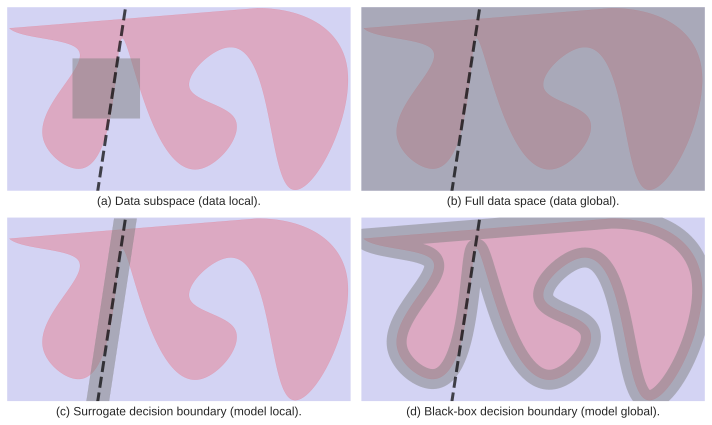

In [4]:
figsize_all = (2 * 5, 2 * 3)
fig = plt.figure(figsize=figsize_all)
fig, ax = plt.subplots(2, 2, figsize=figsize_all)

figsize_piece = (5, 3)
title_loc = -0.11
fig1, ax1 = plot_examples.local_linear_surrogate(
    plot_axis=ax[0, 0], figsize=figsize_piece, eval='inst-loc')
ax1.set_title('(a) Data subspace (data local).', y=title_loc)
fig2, ax2 = plot_examples.local_linear_surrogate(
    plot_axis=ax[0, 1], figsize=figsize_piece, eval='inst-glob')
ax2.set_title('(b) Full data space (data global).', y=title_loc)
fig3, ax3 = plot_examples.local_linear_surrogate(
    plot_axis=ax[1, 0], figsize=figsize_piece, eval='mod-loc')
ax3.set_title('(c) Surrogate decision boundary (model local).', y=title_loc)
fig4, ax4 = plot_examples.local_linear_surrogate(
    plot_axis=ax[1, 1], figsize=figsize_piece, eval='mod-glob')
ax4.set_title('(d) Black-box decision boundary (model global).', y=title_loc)

glue('fig_surrogates_eval', fig, display=False)

```{glue:figure} fig_surrogates_eval
:figwidth: 95%
:name: "fig:surrogates:eval"

Overview of fidelity-based evaluation strategies for surrogates of *tabular* data, using the example of a *local*, *linear* explainer without an interpretable representation.
Panels (a) and (b) show *data-driven* evaluation approaches; the former for a data subspace and the latter for the entire data space (gray shading).
Panels (c) and (d) depict *model-driven* evaluation approaches; the former for the local (surrogate) decision boundary and the latter for the global (black-box) decision boundary.
```

different strategies for tabular data, images can only eb evaluated withing the scope of a single image or sentence.


intuitive visualisation for the local and global, model specific and data-specific visualisations from the thesis.

## Caveats ##

fidelity {cite:p}`rudin2019stop`
stochasticity: random sampling, operating on interpretable representation of tabular data

(text:meta-explainers:surrogates:overview:literature)=
## Additional Resources ##

TODO

Materials

Do a quick overview of surrogate literature.

popular examples are treepan {cite:p}`craven1996extracting` and LIME {cite:p}`ribeiro2016why`,
and a generalisation of LIME bLIMEy, which is modular meta-algorithm for building surrogates